# 예제 3 : 사전 학습 모델 활용 견종 인식

## 라이브러리 불러오기

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout,Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib

## 이미지 경로 지정

In [7]:
data_path=pathlib.Path('./datasets/standford_dogs/Images')

## 데이터 불러오기 및 전처리

In [8]:
train_ds=image_dataset_from_directory(data_path,validation_split=0.2,subset='training',seed=123,image_size=(128,128),batch_size=128)
test_ds=image_dataset_from_directory(data_path,validation_split=0.2,subset='validation',seed=123,image_size=(128,128),batch_size=128)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


## 전이 학습 모델 정의
- DenseNet121 모델 특징 추출기로 사용

In [9]:
base_model=DenseNet121(weights='imagenet',include_top=False,input_shape=(128,128,3))

base_model.trainable = False

cnn=Sequential()
cnn.add(Rescaling(1.0/255.0))
cnn.add(base_model)
cnn.add(Flatten())
cnn.add(Dense(1024,activation='relu'))
cnn.add(Dropout(0.75))
cnn.add(Dense(units=120,activation='softmax'))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## 모델 학습
- 파인 튜닝을 위해 매우 낮은 학습률 사용

In [10]:
cnn.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
hist=cnn.fit(train_ds,epochs=20,validation_data=test_ds,verbose=2)

Epoch 1/20


129/129 - 429s - 3s/step - accuracy: 0.0347 - loss: 5.2811 - val_accuracy: 0.1154 - val_loss: 4.3422
Epoch 2/20
129/129 - 392s - 3s/step - accuracy: 0.0445 - loss: 4.5490 - val_accuracy: 0.1623 - val_loss: 3.9694
Epoch 3/20
129/129 - 405s - 3s/step - accuracy: 0.0502 - loss: 4.4202 - val_accuracy: 0.1747 - val_loss: 3.6244
Epoch 4/20
129/129 - 393s - 3s/step - accuracy: 0.0524 - loss: 4.3372 - val_accuracy: 0.1567 - val_loss: 3.6890
Epoch 5/20
129/129 - 394s - 3s/step - accuracy: 0.0519 - loss: 4.3151 - val_accuracy: 0.1929 - val_loss: 3.4081
Epoch 6/20
129/129 - 397s - 3s/step - accuracy: 0.0560 - loss: 4.2500 - val_accuracy: 0.1684 - val_loss: 3.4855
Epoch 7/20
129/129 - 391s - 3s/step - accuracy: 0.0515 - loss: 4.2536 - val_accuracy: 0.2068 - val_loss: 3.3040
Epoch 8/20
129/129 - 389s - 3s/step - accuracy: 0.0559 - loss: 4.2061 - val_accuracy: 0.1968 - val_loss: 3.2624
Epoch 9/20
129/129 - 399s - 3s/step - accuracy: 0.0578 - loss: 4.1974 - val_accuracy: 0.2053 - val_loss: 3.1639
Epo

## 모델 평가

In [11]:
print('정확도=',cnn.evaluate(test_ds,verbose=0)[1]*100)

정확도= 23.3722060918808


## 모델 저장

In [12]:
cnn.save('cnn_for_stanford_dogs.h5')	# 미세 조정된 모델을 파일에 저장

## 클래스 이름 저장
- train_ds.class_names 속성에 저장된 견종 이름 리스트 불러오기
- pickle 라이브러리를 사용해 이 리스트를 dog_species_names.txt 파일로 저장
- 실습 문제에서 사용

In [13]:
import pickle
f=open('dog_species_names.txt','wb')
pickle.dump(train_ds.class_names,f)
f.close()

## 시각화

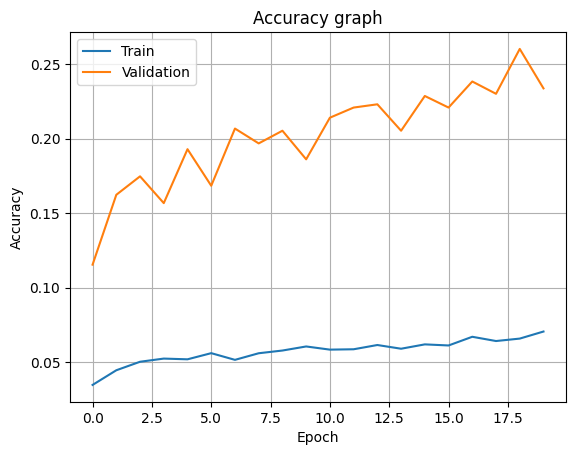

In [14]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy graph')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

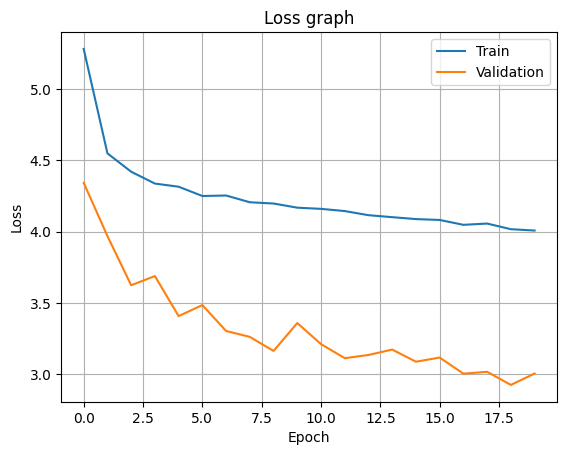

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

# 실습 문제 : 견종 인식 에이전트 만들기

## 라이브러리 불러오기

In [16]:
import cv2 as cv
import numpy as np
import tensorflow as tf
# import winsound
import pickle
import sys
from PyQt5.QtWidgets import *

## 모델 불러오기

In [17]:
cnn=tf.keras.models.load_model('cnn_for_stanford_dogs.h5')	# 모델 읽기
dog_species=pickle.load(open('dog_species_names.txt','rb'))	# 견종 이름

## 메인 윈도우 클래스 정의

In [18]:
class DogSpeciesRecognition(QMainWindow):
    def __init__(self) :
        super().__init__()
        self.setWindowTitle('견종 인식')
        self.setGeometry(200,200,700,100)

        fileButton=QPushButton('강아지 사진 열기',self)
        recognitionButton=QPushButton('품종 인식',self)
        quitButton=QPushButton('나가기',self)

        fileButton.setGeometry(10,10,100,30)
        recognitionButton.setGeometry(110,10,100,30)
        quitButton.setGeometry(510,10,100,30)

        fileButton.clicked.connect(self.pictureOpenFunction)
        recognitionButton.clicked.connect(self.recognitionFunction)
        quitButton.clicked.connect(self.quitFunction)

    def pictureOpenFunction(self):
        fname=QFileDialog.getOpenFileName(self,'강아지 사진 읽기','./')
        self.img=cv.imread(fname[0])
        if self.img is None: sys.exit('파일을 찾을 수 없습니다.')

        cv.imshow('Dog image',self.img)

    def recognitionFunction(self):
        x=np.reshape(cv.resize(self.img,(128,128)),(1,128,128,3))
        res=cnn.predict(x)[0]		# 예측
        top5=np.argsort(-res)[:5]
        top5_dog_species_names=[dog_species[i] for i in top5]
        for i in range(5):
            prob='('+str(res[top5[i]])+')'
            name=str(top5_dog_species_names[i]).split('-')[1]
            cv.putText(self.img,prob+name,(10,100+i*30),cv.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),2)
        cv.imshow('Dog image',self.img)
        # winsound.Beep(1000,500)

    def quitFunction(self):
        cv.destroyAllWindows()
        self.close()

## 실행하기

In [19]:
app=QApplication(sys.argv)
win=DogSpeciesRecognition()
win.show()
app.exec_()

0